## Import Packages

In [7]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pylab as plt
from collections import Counter
import seaborn as sns
from operator import itemgetter
from networkx.algorithms.community import girvan_newman, modularity
from networkx.algorithms import degree_centrality
from networkx.algorithms import betweenness_centrality
from networkx.algorithms import eigenvector_centrality
import itertools

1. Degree Plots
2. Centrality Measures
3. Community Calculation

## Generating directed and weighted networks

In [8]:
# Calculating the degree of nodes and putting it into the list

ori_pre_ban_df = pd.read_csv('data/cleaned_data_before_ban.csv')
ori_post_ban_df = pd.read_csv('data/cleaned_data_after_ban.csv')

# PRE BAN

##### select top 5k transactions for pre ban
pre_ban_df = ori_pre_ban_df.sort_values(by=['value'], ascending=False).head(50)
pre_ban_mono_df = pre_ban_df[(pre_ban_df.from_address_type == 'EOA') & (pre_ban_df.to_address_type == 'EOA')].reset_index(drop=True)
pre_ban_bi_df = pre_ban_df[((pre_ban_df.from_address_type == 'EOA') & (pre_ban_df.to_address_type == 'Contract')) | ((pre_ban_df.from_address_type == 'Contract') & (pre_ban_df.to_address_type == 'EOA'))].reset_index(drop=True)

##### generate monopartite network pre ban
pre_ban_mono = nx.DiGraph()
pre_ban_mono.add_nodes_from(np.unique(np.array(pre_ban_mono_df['from_address'].append(pre_ban_mono_df['to_address']))))
pre_ban_mono.add_weighted_edges_from(list(zip(pre_ban_mono_df['from_address'],pre_ban_mono_df['to_address'],pre_ban_mono_df['value'])))

##### generate bipartite network pre ban
pre_ban_bi_users = np.unique(np.array(pre_ban_bi_df['from_address']))
pre_ban_bi_contracts = np.unique(np.array(pre_ban_bi_df['to_address']))
pre_ban_bi_edges = list(zip(pre_ban_bi_df['from_address'], pre_ban_bi_df['to_address'], pre_ban_bi_df['value']))

pre_ban_bi = nx.DiGraph()
pre_ban_bi.add_nodes_from(pre_ban_bi_users, bipartite=0)
pre_ban_bi.add_nodes_from(pre_ban_bi_contracts, bipartite=1)
pre_ban_bi.add_weighted_edges_from(pre_ban_bi_edges)

# POST BAN

##### select top 5k transactions for post ban
post_ban_df = ori_post_ban_df.sort_values(by=['value'], ascending=False).head(5000)
post_ban_mono_df = post_ban_df[(post_ban_df.from_address_type == 'EOA') & (post_ban_df.to_address_type == 'EOA')].reset_index(drop=True)
post_ban_bi_df = post_ban_df[((post_ban_df.from_address_type == 'EOA') & (post_ban_df.to_address_type == 'Contract')) | ((post_ban_df.from_address_type == 'Contract') & (post_ban_df.to_address_type == 'EOA'))].reset_index(drop=True)

##### generate monopartite network post ban
post_ban_mono = nx.DiGraph()
post_ban_mono.add_nodes_from(np.unique(np.array(post_ban_mono_df['from_address'].append(post_ban_mono_df['to_address']))))
post_ban_mono.add_weighted_edges_from(list(zip(post_ban_mono_df['from_address'],post_ban_mono_df['to_address'],post_ban_mono_df['value'])))

##### generate bipartite network post ban
post_ban_bi_users = np.unique(np.array(post_ban_bi_df['from_address']))
post_ban_bi_contracts = np.unique(np.array(post_ban_bi_df['to_address']))
post_ban_bi_edges = list(zip(post_ban_bi_df['from_address'], post_ban_bi_df['to_address'], post_ban_bi_df['value']))

post_ban_bi = nx.DiGraph()
post_ban_bi.add_nodes_from(post_ban_bi_users, bipartite=0)
post_ban_bi.add_nodes_from(post_ban_bi_contracts, bipartite=1)
post_ban_bi.add_weighted_edges_from(post_ban_bi_edges)

# Degree 

## Summary on degree distribution

In [10]:
network = pre_ban_bi
dv = dict(network.degree())
k = list(dv.values())

# Creating mean, min, max and sd for degree

degreemean = np.mean(k)
degreemin = np.min(k)
degreemax = np.max(k)
degreestd = np.std(k)

## Plotting Degree Distribution 1: Histogram (Overall, In-Degree, Out-Degree)

A plot containing 3 graphs (overall, in-degree and out-degree distribution)

In [11]:
# Creating parameters for graph

# Overall (formula is very similar as the degree distribution summary)

k_overall = sorted([d for n, d in network.degree()], reverse=True) #Gets all the degree in a list
p_k_overall = np.unique(k_overall, return_counts=True)
average = sum(k_overall)/len(network.nodes) # Calculate the average to be used for poisson at graph 2

## Indegree

k_indegree = sorted([d for n, d in network.in_degree()], reverse=True)
p_k_indegree = np.unique(k_indegree, return_counts=True)
average_in = sum(k_indegree)/len(network.nodes)

## Outdegree

k_outdegree = sorted([d for n, d in network.out_degree()], reverse=True)
p_k_outdegree = np.unique(k_outdegree, return_counts=True)
average_out = sum(k_outdegree)/len(network.nodes)

In [49]:
def plot_degree_dist(network1, network2, suptitle_label, figsize=(12,8)):
    alpha = 0.5
    plt.suptitle(suptitle_label, fontsize=15)
    fig = plt.figure(figsize=figsize,constrained_layout=True)

    # Overall (formula is very similar as the degree distribution summary)
    k_overall = sorted([d for n, d in network1.degree()], reverse=True) #Gets all the degree in a list
    p_k_overall = np.unique(k_overall, return_counts=True)
    average = sum(k_overall)/len(network.nodes) # Calculate the average to be used for poisson at graph 2

    # create plot
    ax1 = fig.add_subplot(231)
    # plot data
    ax1.bar(p_k_overall[0], p_k_overall[1], width=1, color="k", edgecolor="black",alpha=alpha)
    # transform the scale of axes
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    # aesthetics
    ax1.set_title("Degree Dist. Before Ban")
    ax1.set_ylabel("Count")
    ax1.set_xlabel("Degree")

    ## Indegree Plot
    k_indegree = sorted([d for n, d in network1.in_degree()], reverse=True)
    p_k_indegree = np.unique(k_indegree, return_counts=True)
    average_in = sum(k_indegree)/len(network.nodes)

    # create plot
    ax2 = fig.add_subplot(232)
    # plot data
    ax2.bar(p_k_indegree[0], p_k_indegree[1], width=1, color="r", edgecolor="black",alpha=alpha)
    # transform the scale of axes
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    # aesthetics
    ax2.set_title("In-Degree Dist. Before Ban")
    ax2.set_ylabel("Count")
    ax2.set_xlabel("Degree")

    ## OutDegree Plot
    k_outdegree = sorted([d for n, d in network1.out_degree()], reverse=True)
    p_k_outdegree = np.unique(k_outdegree, return_counts=True)
    average_out = sum(k_outdegree)/len(network.nodes)

    # create plot
    ax3 = fig.add_subplot(233)
    # plot data
    ax3.bar(p_k_outdegree[0], p_k_outdegree[1], width=1, color="g", edgecolor="black",alpha=alpha)
    # transform the scale of axes
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    # aesthetics
    ax3.set_title("Out-Degree Dist. Before Ban")
    ax3.set_ylabel("Count")
    ax3.set_xlabel("Degree")

    # Overall (formula is very similar as the degree distribution summary)
    k_overall = sorted([d for n, d in network2.degree()], reverse=True) #Gets all the degree in a list
    p_k_overall = np.unique(k_overall, return_counts=True)
    average = sum(k_overall)/len(network.nodes) # Calculate the average to be used for poisson at graph 2
    
    # create plot
    ax4 = fig.add_subplot(234)
    # plot data
    ax4.bar(p_k_overall[0], p_k_overall[1], width=1, color="k", edgecolor="black",alpha=alpha)
    # transform the scale of axes
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    # aesthetics
    ax4.set_title("Degree Dist. After Ban")
    ax4.set_ylabel("Count")
    ax4.set_xlabel("Degree")

    ## Indegree Plot
    k_indegree = sorted([d for n, d in network2.in_degree()], reverse=True)
    p_k_indegree = np.unique(k_indegree, return_counts=True)
    average_in = sum(k_indegree)/len(network.nodes)

    # create plot
    ax5 = fig.add_subplot(235)
    # plot data
    ax5.bar(p_k_indegree[0], p_k_indegree[1], width=1, color="r", edgecolor="black",alpha=alpha)
    # transform the scale of axes
    ax5.set_xscale('log')
    ax5.set_yscale('log')
    # aesthetics
    ax5.set_title("In-Degree Dist. After Ban")
    ax5.set_ylabel("Count")
    ax5.set_xlabel("Degree")

    ## OutDegree Plot
    k_outdegree = sorted([d for n, d in network2.out_degree()], reverse=True)
    p_k_outdegree = np.unique(k_outdegree, return_counts=True)
    average_out = sum(k_outdegree)/len(network.nodes)

    # create plot
    ax6 = fig.add_subplot(236)
    # plot data
    ax6.bar(p_k_outdegree[0], p_k_outdegree[1], width=1, color="g", edgecolor="black",alpha=alpha)
    # transform the scale of axes
    ax6.set_xscale('log')
    ax6.set_yscale('log')
    # aesthetics
    ax6.set_title("Out-Degree Dist. After Ban")
    ax6.set_ylabel("Count")
    ax6.set_xlabel("Degree")

    plt.show()

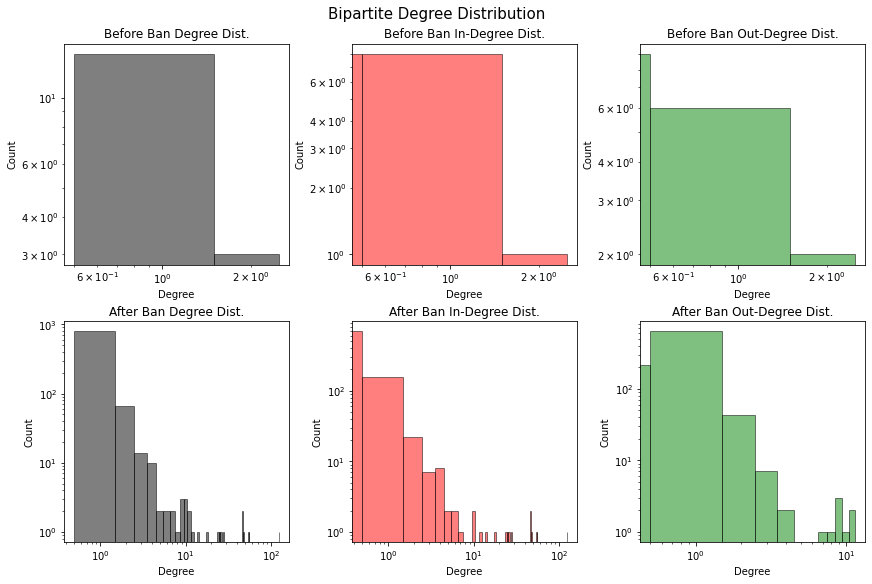

In [47]:
# Distribution Plot (Log Scale)

# Overall
# create figure
alpha = 0.5
fig = plt.figure(figsize=(12, 8),constrained_layout=True)

network = pre_ban_bi
# Overall (formula is very similar as the degree distribution summary)
k_overall = sorted([d for n, d in network.degree()], reverse=True) #Gets all the degree in a list
p_k_overall = np.unique(k_overall, return_counts=True)
average = sum(k_overall)/len(network.nodes) # Calculate the average to be used for poisson at graph 2

# create plot
ax1 = fig.add_subplot(231)
# plot data
ax1.bar(p_k_overall[0], p_k_overall[1], width=1, color="k", edgecolor="black",alpha=alpha)
# transform the scale of axes
ax1.set_xscale('log')
ax1.set_yscale('log')
# aesthetics
ax1.set_title("Before Ban Degree Dist.")
ax1.set_ylabel("Count")
ax1.set_xlabel("Degree")

## Indegree Plot
k_indegree = sorted([d for n, d in network.in_degree()], reverse=True)
p_k_indegree = np.unique(k_indegree, return_counts=True)
average_in = sum(k_indegree)/len(network.nodes)

# create plot
ax2 = fig.add_subplot(232)
# plot data
ax2.bar(p_k_indegree[0], p_k_indegree[1], width=1, color="r", edgecolor="black",alpha=alpha)
# transform the scale of axes
ax2.set_xscale('log')
ax2.set_yscale('log')
# aesthetics
ax2.set_title("Before Ban In-Degree Dist.")
ax2.set_ylabel("Count")
ax2.set_xlabel("Degree")

## OutDegree Plot
k_outdegree = sorted([d for n, d in network.out_degree()], reverse=True)
p_k_outdegree = np.unique(k_outdegree, return_counts=True)
average_out = sum(k_outdegree)/len(network.nodes)

# create plot
ax3 = fig.add_subplot(233)
# plot data
ax3.bar(p_k_outdegree[0], p_k_outdegree[1], width=1, color="g", edgecolor="black",alpha=alpha)
# transform the scale of axes
ax3.set_xscale('log')
ax3.set_yscale('log')
# aesthetics
ax3.set_title("Before Ban Out-Degree Dist.")
ax3.set_ylabel("Count")
ax3.set_xlabel("Degree")

network = post_ban_bi
# Overall (formula is very similar as the degree distribution summary)
k_overall = sorted([d for n, d in network.degree()], reverse=True) #Gets all the degree in a list
p_k_overall = np.unique(k_overall, return_counts=True)
average = sum(k_overall)/len(network.nodes) # Calculate the average to be used for poisson at graph 2

# create plot
ax4 = fig.add_subplot(234)
# plot data
ax4.bar(p_k_overall[0], p_k_overall[1], width=1, color="k", edgecolor="black",alpha=alpha)
# transform the scale of axes
ax4.set_xscale('log')
ax4.set_yscale('log')
# aesthetics
ax4.set_title("After Ban Degree Dist.")
ax4.set_ylabel("Count")
ax4.set_xlabel("Degree")

## Indegree Plot
k_indegree = sorted([d for n, d in network.in_degree()], reverse=True)
p_k_indegree = np.unique(k_indegree, return_counts=True)
average_in = sum(k_indegree)/len(network.nodes)

# create plot
ax5 = fig.add_subplot(235)
# plot data
ax5.bar(p_k_indegree[0], p_k_indegree[1], width=1, color="r", edgecolor="black",alpha=alpha)
# transform the scale of axes
ax5.set_xscale('log')
ax5.set_yscale('log')
# aesthetics
ax5.set_title("After Ban In-Degree Dist.")
ax5.set_ylabel("Count")
ax5.set_xlabel("Degree")

## OutDegree Plot
k_outdegree = sorted([d for n, d in network.out_degree()], reverse=True)
p_k_outdegree = np.unique(k_outdegree, return_counts=True)
average_out = sum(k_outdegree)/len(network.nodes)

# create plot
ax6 = fig.add_subplot(236)
# plot data
ax6.bar(p_k_outdegree[0], p_k_outdegree[1], width=1, color="g", edgecolor="black",alpha=alpha)
# transform the scale of axes
ax6.set_xscale('log')
ax6.set_yscale('log')
# aesthetics
ax6.set_title("After Ban Out-Degree Dist.")
ax6.set_ylabel("Count")
ax6.set_xlabel("Degree")

plt.suptitle("Bipartite Degree Distribution", fontsize=15)
plt.show()

## Plotting Law Graph (Overall, In-degree, Out-degree)

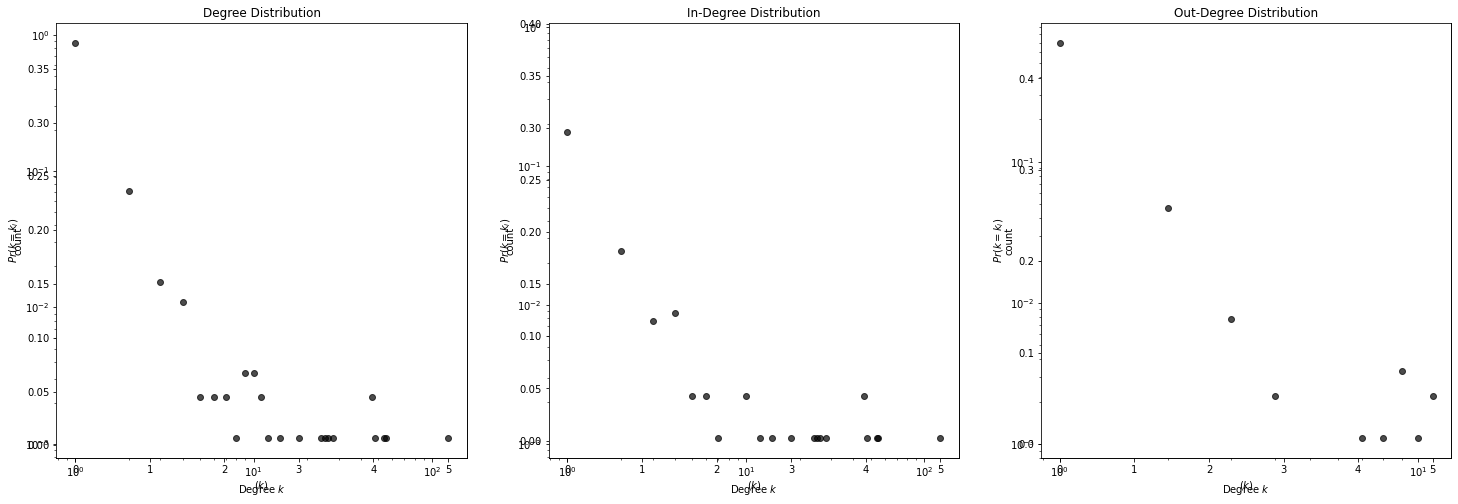

In [46]:
############## POWER LAW ONLY FOR OVERALL

# Power Law Graph 

# %% network degree distribution

### Creating the overall graph

## 1.1 - Power Law (Overall)

# Create n value for finding the k below
n = len(network.nodes)

# get nodal degree 'k' data as list
k_g = sorted([d for n, d in network.degree()], reverse=True)

# get 'p_k'
# --+ point-to-point probability
p_k = np.unique(k_g, return_counts=True)
# --+ cumulative probability
cp_k = np.unique(k_g, return_index=True)



# poisson distribution

# Creating parameters for poisson (lam = average degree of graph)
# Average value is created at the poisson parameter codes above

poisson_dist = np.random.poisson(lam=average, size=len(network.nodes()))
k_poisson = Counter(poisson_dist)
n_poisson = len(poisson_dist)

x_poisson = list(k_poisson.keys())
x_poisson = pd.DataFrame(x_poisson)
y_poisson = list(k_poisson.values())
y_poisson = pd.DataFrame(y_poisson)


# create figure
fig = plt.figure(figsize=(25, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(x_poisson, y_poisson/n_poisson, color='red')

ax1.set_ylabel("count")
ax1.set_xlabel("($k$)")

# add plot
ax0 = fig.add_subplot(1, 3, 1)

# point-to-point data
# --+ plot data
ax0.scatter(p_k[0], p_k[1]/n, marker='o', color='black', alpha=0.7)
# --+ title
ax0.set_title("Degree Distribution")
# --+ labels
ax0.set_ylabel("$Pr(k = k_{i})$")
ax0.set_xlabel("Degree $k$")
ax0.set_yscale('log')
ax0.set_xscale('log')


# Now we repeat the whole process again with in and out-degree. Maybe a function would 
# be better...

## 2.1 Power Law (In-Degree)

# get nodal degree 'k' data as list
k_g = sorted([d for n, d in network.in_degree()], reverse=True) # I used the same k_g variable, not sure if should rename

# get 'p_k'
# --+ point-to-point probability
p_k = np.unique(k_g, return_counts=True)
# --+ cumulative probability
cp_k = np.unique(k_g, return_index=True)


## 2.2 Poisson Distribution

# poisson distribution
# Creating parameters for poisson (lam = average degree of graph)

poisson_dist = np.random.poisson(lam=average_in, size=len(network.nodes()))
k_poisson = Counter(poisson_dist)
n_poisson = len(poisson_dist)

x_poisson = list(k_poisson.keys())
x_poisson = pd.DataFrame(x_poisson)
y_poisson = list(k_poisson.values())
y_poisson = pd.DataFrame(y_poisson)


# create figure

ax3 = fig.add_subplot(1, 3, 2)
ax3.scatter(x_poisson, y_poisson/n_poisson, color='red')

ax3.set_ylabel("count")
ax3.set_xlabel("($k$)")

# add plot
ax4 = fig.add_subplot(1, 3, 2)

# point-to-point data
# --+ plot data
ax4.scatter(p_k[0], p_k[1]/n, marker='o', color='black', alpha=0.7)
# --+ title
ax4.set_title("In-Degree Distribution")
# --+ labels
ax4.set_ylabel("$Pr(k = k_{i})$")
ax4.set_xlabel("Degree $k$")
ax4.set_yscale('log')
ax4.set_xscale('log')


## 3.1 Power Law (Out-Degree)

# get nodal degree 'k' data as list
k_g = sorted([d for n, d in network.out_degree()], reverse=True)

# get 'p_k'
# --+ point-to-point probability
p_k = np.unique(k_g, return_counts=True)
# --+ cumulative probability
cp_k = np.unique(k_g, return_index=True)



## 3.2 Poisson Distribution (Out-Degree)

# Creating parameters for poisson (lam = average degree of graph)

poisson_dist = np.random.poisson(lam=average_out, size=len(network.nodes()))
k_poisson = Counter(poisson_dist)
n_poisson = len(poisson_dist)

x_poisson = list(k_poisson.keys())
x_poisson = pd.DataFrame(x_poisson)
y_poisson = list(k_poisson.values())
y_poisson = pd.DataFrame(y_poisson)


# create figure

ax5 = fig.add_subplot(1, 3, 3)
ax5.scatter(x_poisson, y_poisson/n_poisson, color='red')

ax5.set_ylabel("count")
ax5.set_xlabel("($k$)")

# add plot
ax6 = fig.add_subplot(1, 3, 3)

# point-to-point data
# --+ plot data
ax6.scatter(p_k[0], p_k[1]/n, marker='o', color='black', alpha=0.7)
# --+ title
ax6.set_title("Out-Degree Distribution")
# --+ labels
ax6.set_ylabel("$Pr(k = k_{i})$")
ax6.set_xlabel("Degree $k$")
ax6.set_yscale('log')
ax6.set_xscale('log')


# show plot (ax0+ax1 = normal, ax3+4 = in, ax5+6 = out)
plt.show()

# Centrality

## Betweenness Centrality

In [41]:
# Calculating the Betweenness Centrality for a network
bet_centrality = nx.betweenness_centrality(network)  # should take a few minutes
nx.set_node_attributes(network, bet_centrality, 'betweenness centrality') 

# Creating the sorted_betweenness value
sorted_betweenness = sorted(
    bet_centrality.items(), key=itemgetter(1), reverse=True)

# Finding the summary stats on between centrality
bet_list = list(bet_centrality.values())

betmean = np.mean(bet_list)
betmin = np.min(bet_list)
betmax = np.max(bet_list)
betstd = np.std(bet_list)

## Eigenvector Centrality

In [42]:
# Calculating the Eigenvector CEntrality for a network
ev_centrality = nx.eigenvector_centrality(network, max_iter=200)
nx.set_node_attributes(network, ev_centrality, 'eigenvector centrality')

# Creating the sorted_ev_centrality value
sorted_ev_centrality = sorted(
    ev_centrality.items(), key=itemgetter(1), reverse=True)

# Finding the summary stats on eigenvector centrality
eg_list = list(ev_centrality.values())

egmean = np.mean(eg_list)
egmin = np.min(eg_list)
egmax = np.max(eg_list)
egstd = np.std(eg_list)

## Degree Centrality

Same format as Eigenvector and Betweenness so for comments, see there

In [43]:
deg_centrality = nx.degree_centrality(network)
nx.set_node_attributes(network, deg_centrality, 'degree centrality')
sorted_deg_centrality = sorted(
    deg_centrality.items(), key=itemgetter(1), reverse=True)

deg_list = list(deg_centrality.values())

degcenmean = np.mean(deg_list)
degcenmin = np.min(deg_list)
degcenmax = np.max(deg_list)
degcenstd = np.std(deg_list)

## Closeness Centrality 

In [44]:
close_centrality = nx.closeness_centrality(network)
nx.set_node_attributes(network, close_centrality, 'closeness centrality')

sorted_close_centrality = sorted(
    close_centrality.items(), key=itemgetter(1), reverse=True)


close_list = list(close_centrality.values())

closemean = np.mean(close_list)
closemin = np.min(close_list)
closemax = np.max(close_list)
closestd = np.std(close_list)

## Visualising the Centrality 

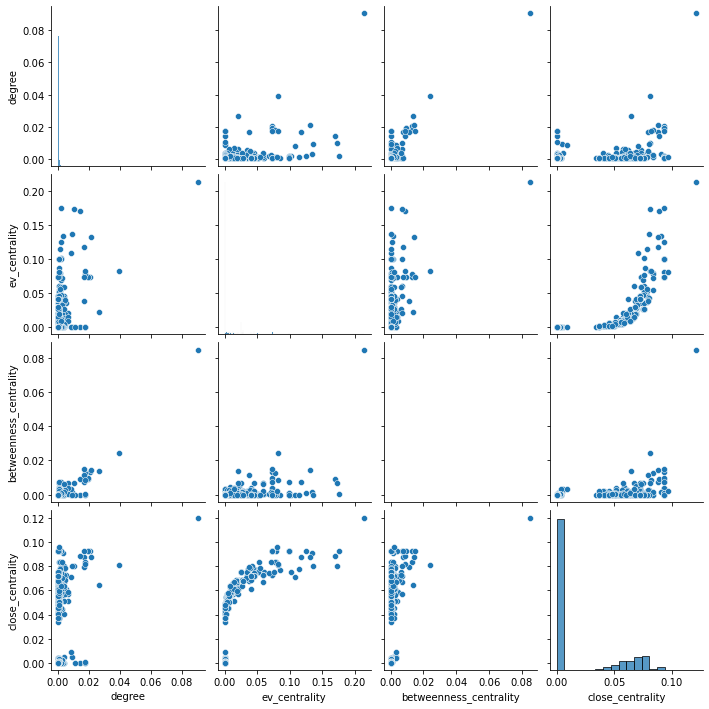

In [45]:
cen_df = pd.DataFrame({'degree': deg_centrality, 'ev_centrality': ev_centrality,
                   'betweenness_centrality': bet_centrality, 'close_centrality': close_centrality}
                )
# --+ correlation matrix
cen_df.corr()
# --+ scatter plot matrix
sns.pairplot(cen_df)

Creating a Summary Table 

In [49]:
# I'm sure there is a much better way to create this
summarytable = pd.DataFrame()

summarytable['closeness'] = (closemean, closemin, closemax, closestd)
summarytable['eigenvector'] = (egmean, egmin, egmax, egstd)
summarytable['betweenness'] = (betmean, betmin, betmax, betstd)
summarytable['degree centrality'] = (degcenmean, degcenmin, degcenmax, degcenstd)
summarytable['degree'] = (degreemean, degreemin, degreemax, degreestd)
summarytable

,closeness,eigenvector,betweenness,degree centrality,degree
0,0.018352,6.855955e-03,0.000191,0.000679,2.021477
1,0.000000,3.254825e-15,0.000000,0.000336,1.000000
2,0.120624,2.139830e-01,0.084761,0.090299,269.000000
3,0.030124,1.698724e-02,0.001826,0.002256,6.721013


In [47]:
# I created this as a reference for all the variables I made

# closemean
# closemin
# closemax
# closestd


# egmean
# egmin
# egmax
# egstd

# betmean
# betmin
# betmax 
# betstd

# degcenmean 
# degcenmin 
# degcenmax 
# degcenstd 


# degreemean
# degreemin
# degreemax
# degreestd

# Community

## Girvan-Newman Method (aka the one that took a long time)

In [57]:
network = pre_ban_mono
solutions = girvan_newman(network)

# alternative paritioning solutions to consider
k = 10

###############################################################################
def iterator_slice(iterator, length):
    iterator = iter(iterator)
    while True:
        res = tuple(itertools.islice(iterator, length))
        if not res:
            break
        yield res
# iterator_slice(solutions, k)
###############################################################################

# register modularity scores
modularity_scores = dict()
# iterate over solutions
test1=[];test2=[];test3=[];test4=[]
for community in itertools.islice(solutions, k):
    test1.append(community)
    # solution = list(sorted(c) for c in community)
    # test2.append(solution)
    # score = modularity(network, solution)
    # test3.append(score)
    # modularity_scores[len(solution)] = score

<generator object iterator_slice at 0x000001A97965A7B0>

In [52]:
network = pre_ban_mono
solutions = girvan_newman(network)
# alternative paritioning solutions to consider
k = 10
# register modularity scores
modularity_scores = dict()
# iterate over solutions
for community in itertools.islice(solutions, k):
    solution = list(sorted(c) for c in community)
    score = modularity(network, solution)
    modularity_scores[len(solution)] = score


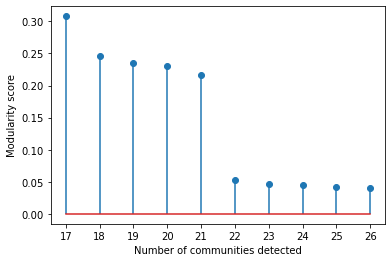

In [53]:
# plot modularity data
fig = plt.figure()
pos = list(modularity_scores.keys())
values = list(modularity_scores.values())
ax = fig.add_subplot(1, 1, 1)
ax.stem(pos, values)
ax.set_xticks(pos)
ax.set_xlabel(r'Number of communities detected')
ax.set_ylabel(r'Modularity score')
plt.show()

In [ ]:
comp = girvan_newman(network)

In [ ]:
user_solutions

<generator object girvan_newman at 0x000001BA220BFDD0>

## The Louvain Method (aka the one that took a few seconds)

In [ ]:
# import community as community_louvain

In [ ]:
# Creates the Louvain class

# Note that this ONLY works with undirected network. May need to artificially generate
# an undirected copy of our graph
partition = community_louvain.best_partition(network)

# Grouping nodes via communities
max_k_w = []
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys()
                  if partition[nodes] == com]
    max_k_w = max_k_w + [list_nodes]

In [ ]:
# How to check the number of communities
len(max_k_w)


In [ ]:
# Checking to see how many communities are in community 1
len(max_k_w[0])    # how many nodes are in that community

In [ ]:
# Locating the communtiy of binance

binance_community = partition['0x28c6c06298d514db089934071355e5743bf21d60'] 
len(max_k_w[binance_community])

In [ ]:
# Others

# some other functions
num_community = len(max_k_w)
        self.num_community = num_community
        print('Network has' + num_community + ' number of communities')